# EVAL.AI malware detection contest
## Eli Belkind
## Itamar Almog
## Koral Elbaz

In [1]:
'''we rely mainly on sklearn library for the project'''
from statistics import mean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from numpy import log
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
'''we use 3 different data sets'''
ustc = pd.read_csv("C:\\Users\\elobl\\PycharmProjects\\contest\\datasets\\ustc\\xy_train.csv")
mta = pd.read_csv('C:\\Users\\elobl\\PycharmProjects\\contest\\datasets\\mta\\xy_train.csv')
zero = pd.read_csv('C:\\Users\\elobl\\PycharmProjects\\contest\\datasets\\zero\\xy_train.csv')

In [21]:
'''for every data set filter features.
the features we dropped are either non generic , do not add new information or unusable because of strings and NAN'''
def dropF(df,set):
    udrop = ['label', 'malware_family', 'src_ip', 'dst_ip', 'src_oui', 'dst_oui', 'application_name',
                 'application_category_name', 'udps.n_bytes', 'udps.stnn_image', 'udps.protocol_header_fields',
                 'Unnamed: 0.1', 'expiration_id', 'bidirectional_cwr_packets', 'bidirectional_ece_packets',
                 'bidirectional_urg_packets', 'src2dst_cwr_packets', 'src2dst_ece_packets', 'src2dst_urg_packets',
                 'dst2src_cwr_packets', 'dst2src_ece_packets', 'dst2src_urg_packets', 'client_fingerprint',
                 'server_fingerprint', 'user_agent', 'content_type', 'udps.n_bytes_per_packet', 'src_mac', 'dst_mac',
                 'vlan_id', 'requested_server_name', 'file_name','ip_version','application_is_guessed'
                 ,'dst2src_first_seen_ms','dst2src_last_seen_ms','src2dst_last_seen_ms','src2dst_first_seen_ms'
                 ,'src_port','dst_port','bidirectional_last_seen_ms','bidirectional_first_seen_ms','protocol']
    mdrop = ['label', 'malware_family', 'src_ip', 'dst_ip', 'src_oui', 'dst_oui', 'udps.n_bytes', 'udps.stnn_image',
                 'udps.protocol_header_fields', 'expiration_id', 'bidirectional_cwr_packets',
                 'bidirectional_ece_packets', 'bidirectional_urg_packets', 'src2dst_cwr_packets', 'src2dst_ece_packets',
                 'src2dst_urg_packets', 'dst2src_cwr_packets', 'dst2src_ece_packets', 'dst2src_urg_packets',
                 'client_fingerprint', 'server_fingerprint', 'user_agent', 'content_type', 'udps.n_bytes_per_packet',
                 'src_mac', 'dst_mac', 'vlan_id', 'requested_server_name','ip_version','application_is_guessed'
                 ,'dst2src_first_seen_ms','dst2src_last_seen_ms','src2dst_last_seen_ms','src2dst_first_seen_ms'
                 ,'application_name','application_category_name','requested_server_name','file_name'
                 ,'src_port','dst_port','bidirectional_last_seen_ms','bidirectional_first_seen_ms','protocol']
    zdrop = ['label', 'malware_family', 'src_ip', 'dst_ip', 'src_oui', 'dst_oui', 'udps.n_bytes', 'udps.stnn_image',
                 'udps.protocol_header_fields', 'expiration_id', 'bidirectional_cwr_packets',
                 'bidirectional_ece_packets', 'bidirectional_urg_packets', 'src2dst_cwr_packets', 'src2dst_ece_packets',
                 'src2dst_urg_packets', 'dst2src_cwr_packets', 'dst2src_ece_packets', 'dst2src_urg_packets',
                 'client_fingerprint', 'server_fingerprint', 'user_agent', 'content_type', 'udps.n_bytes_per_packet',
                 'src_mac', 'dst_mac', 'vlan_id', 'requested_server_name','ip_version','application_is_guessed'
                 ,'dst2src_first_seen_ms','dst2src_last_seen_ms','src2dst_last_seen_ms','src2dst_first_seen_ms'
                 ,'src_port','dst_port','bidirectional_last_seen_ms','bidirectional_first_seen_ms','protocol']
    if set == 0:
        df = df.drop(zdrop, axis=1)
    elif set == 1:
        df = df.drop(udrop, axis=1)
    else:
        df = df.drop(mdrop, axis=1)
    cor = df.corr()
    r = []
    for i in range(len(cor)):
        for j in range(len(cor.iloc[0])):
            if i == j:
                continue
            if cor.iloc[i][j] >= 0.9:
                r.append(df.columns[i])
    df = df.drop(r, axis=1)

    va = df.var()
    v = []
    for i in df.columns:
        if 0.1 > va[i] > -0.1:
            v.append(i)
    df = df.drop(v, axis=1)
    

    return df

Becuase the ML algorithm need a single numerical value for each feature, we had to find a way to extract the most inforamtion from the arrays in a single numarical form. from our experiments mean is currently the best way to unify the array data to a single value. from the image array we extracted the data packets statistics as the rest are to similar to other features
to be usefull.

In [23]:
'''for the features made from arrays we normilize the data by convering the data to a singal value for every row'''
def norm(df):
    #df['udps.stnn_image'] = df['udps.stnn_image'].transform(literal_eval)
    tmp = df.iloc[0]['udps.stnn_image']
    im = []
    for i in tmp[4]:
        im.append([i])
    image = pd.DataFrame(np.array(im).T, columns=['iat max', 'iat min', 'iat mean', 'iat stddev', 'iat skew',
                                                  'size min', 'size max', 'size mean', 'size stddev', 'size skew',
                                                  '#packets', '#bytes', 'pkts/time', 'bytes/time'])
    for i in df['udps.stnn_image'].index:
        if i == 0:
            continue
        tmp = df.iloc[i]['udps.stnn_image']
        im = []
        for j in tmp[4]:
            im.append([j])
        img = pd.DataFrame(np.array(im).T, index=[i],
                           columns=['iat max', 'iat min', 'iat mean', 'iat stddev', 'iat skew',
                                                  'size min', 'size max', 'size mean', 'size stddev', 'size skew',
                                                  '#packets', '#bytes', 'pkts/time', 'bytes/time'])
        image = pd.concat([image, img], axis=0)
    df = pd.concat([df, image], axis=1)
    df['udps.protocol_header_fields'] = df['udps.protocol_header_fields'].transform(literal_eval)
    a = []
    b = []
    c = []
    d = []
    for i in df.index:
        head = np.array(df.iloc[i]['udps.protocol_header_fields'])
        a.append(mean(head[0]))
        b.append(mean(head[1]))
        c.append(mean(head[2]))
        d.append(mean(head[3]))
    df = df.assign(head1=a, head2=b, head3=c, head4=d)

    return df

In order to begin to think of an appropriate model of ML for this task,
we had visualize the data on a graph and see what classifications are isolated
and what cassidications are hardly distinguishable. 

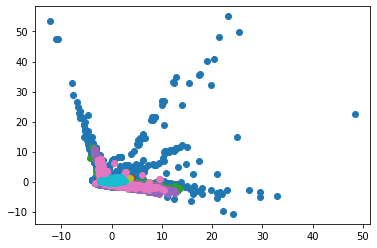

In [24]:
'''we eanted to view the data on a graph so we used pca to visiualize the data'''
ucopy = ustc.copy()
label = ucopy['malware_family']
ucopy = norm(ucopy)
ucopy = dropF(ucopy,1)

scaling=StandardScaler()
scaling.fit(ucopy)
Scaled_data=scaling.transform(ucopy)
principal=PCA(n_components=2)
principal.fit(Scaled_data)
x=principal.transform(Scaled_data)
y = pd.DataFrame(x,columns=['x','y'])
y = y.assign(tag=label,axis=1)
u = label.unique()
for i in u:
    d = y[y['tag']==i]
    plt.scatter(d['x'], d['y'])

plt.show()

<AxesSubplot:>

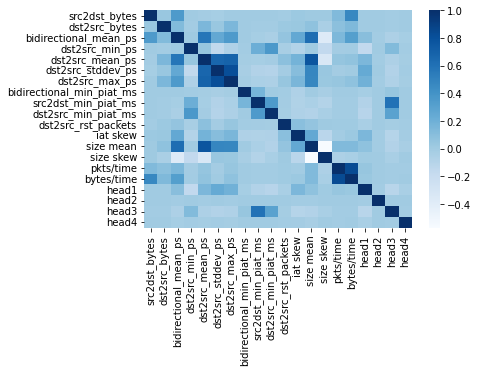

In [25]:
'''the heat map of feature corrolation'''
sns.heatmap(ucopy[ucopy.columns[:]].corr(), cmap='Blues')

In our testing 3 models had sufficient accuracy to be relavent for this project:
random forest
gradient boost
hist gradient boost
to make use of all their strength we decided to ensemble them in a single soft voting model.

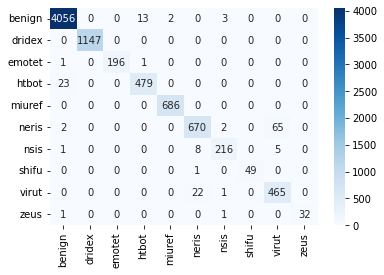

In [7]:
'''we use 3 ensemble models to get best results, to improve the detection we use a soft voting system.'''
x_train, x_test, y_train, y_test = train_test_split(ucopy, label, test_size=0.20, stratify=label)
model1 = RandomForestClassifier(n_estimators=100)
model2 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)
model3 = HistGradientBoostingClassifier(max_iter=100, max_depth=5)
model = VotingClassifier(estimators=[('RF',model2),('GB',model1),("HGB",model3)], voting='soft')
model.fit(x_train, y_train)
predictions = model.predict(x_test)
true_labels = y_test
cf_matrix = confusion_matrix(true_labels, predictions)

heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=np.unique(label), yticklabels=np.unique(label))

To verify and check our model we use the mean of 5-fold cross validation and compare with previouse tests.

In [ ]:
'''to test our result we use 5-fold cross validation'''
print('auccracy:',mean(cross_val_score(model, ucopy, label, cv=5)))
print('precision:',mean(cross_val_score(model, ucopy, label, cv=5, scoring='precision_macro')))
print('recall:',mean(cross_val_score(model, ucopy, label, cv=5, scoring='recall_macro')))

In [20]:
'''a function that recives a data frame a set to learn and a label type to predict'''
def pred(df,set,label_type)
    if set == 0:
        learn = pd.read_csv('C:\\Users\\elobl\\PycharmProjects\\contest\\datasets\\zero\\xy_train.csv')
    elif set == 1:
        learn = pd.read_csv("C:\\Users\\elobl\\PycharmProjects\\contest\\datasets\\ustc\\xy_train.csv")
    else:
        learn = pd.read_csv('C:\\Users\\elobl\\PycharmProjects\\contest\\datasets\\mta\\xy_train.csv')
    label = learn[label_type]
    learn = norm(learn)
    learn = dropF(learn,set)
    df = norm(df)
    df = df[learn.columns]
    model1 = RandomForestClassifier(n_estimators=100)
    model2 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)
    model3 = HistGradientBoostingClassifier(max_iter=100, max_depth=5)
    model = VotingClassifier(estimators=[('RF',model2),('GB',model1),("HGB",model3)], voting='soft')
    model.fit(learn, label)
    return model.predict(df)

array(['benign', 'malware', 'benign', ..., 'benign', 'malware', 'malware'],
      dtype=object)

our results from eval.ai
zero detection test {"Accuracy": 0.60835, "Precision": 0.6104155979794751, "Recall": 0.608028471431207, "F1":0.6060897181835445}
mta detection test {"Accuracy": 0.9957308743169399, "Precision": 0.9957475858505207, "Recall": 0.99573087431694, "F1":0.995730838338833}
mta family classification test {"Accuracy": 0.9549180327868853, "Precision": 0.9098301578668182, "Recall": 0.8710613466944275, "F1": 0.8887793963626642}
ustc detection test {"Accuracy": 0.9969931271477663, "Precision": 0.9969949025278164, "Recall": 0.9969931271477663, "F1":0.9969931244624537}
ustc family classification test {"Accuracy": 0.9859965635738832, "Precision": 0.9818352849229027, "Recall": 0.9765883649132624, "F1": 0.9786742857201892}
